In [22]:
import numpy as np
import os
import shutil
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from pylab import *
import random
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.utils import normalize, to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.optimizers import RMSprop
from keras.models import load_model

In [8]:
folder1 = "/content/dataset/DATASET/TRAIN/R"
folder2 = "/content/dataset/DATASET/TRAIN/O"
folder3="/content/dataset/DATASET/TEST/R"
folder4="/content/dataset/DATASET/TEST/O"

train_path = "/content/train_data"
test_path="/content/test_data"
val_path="/content/val_data"

res_train="/content/resized_data"
res_test="/content/resized_testdata"
res_val="/content/resized_valdata"

#newres_train="/content/newresized_data"
#newres_test="/content/newresized_testdata"
#newres_val="/content/newresized_valdata"

#finres_train="/content/finresized_data"
#finres_test="/content/finresized_testdata"
#finres_val="/content/finresized_valdata"

col_path="/content/colorj_data"
flip_path="/content/flip_data"
aug_path="/content/aug_data"

randcrop_path="/content/randcrop_data"

#testcrop_path="/content/crop_testdata"
#compress_path="/content/compress_data"


#augcrop_path="/content/aug_crop_valdata"
#augrandcrop_path="/content/augrandcrop_data"

colv_path="/content/colorj_valdata"
flipv_path="/content/flip_valdata"
augv_path="/content/aug_valdata"

crop_path="/content/crop_valdata"

Recyclable -> 1,
Organic -> 0

Train=22564, Test=2513

Total=25077

In [9]:
def all_data(folder1,folder2,outpath):
  
  #creating directory
  if not os.path.exists(outpath):
          os.mkdir(outpath)
          print("Directory " , outpath ,  " Created ")
  else:    
          print("Directory " , outpath ,  " already exists")
  
  
  #recyclable waste
  rfiles = [f1 for f1 in os.listdir(folder1) if os.path.isfile(os.path.join(folder1, f1))]

  j=1
  for i in range(len(rfiles)):
    
     os.rename(folder1 + "/" + rfiles[i], outpath+'/1_'+str(j)+ '.jpg') #renaming
     j+=1

  #organic waste
  ofiles = [f2 for f2 in os.listdir(folder2) if os.path.isfile(os.path.join(folder2, f2))]

  k=1
  for i in range(len(ofiles)):
     os.rename(folder2 + "/" + ofiles[i], outpath+'/0_'+str(k)+ '.jpg') #renaming
     k+=1

In [10]:
all_data(folder1,folder2,train_path)

Directory  /content/train_data  Created 


In [11]:
all_data(folder3,folder4,test_path)

Directory  /content/test_data  Created 


Splitting test into test and val

In [12]:
def split_testval():
  
  if not os.path.exists(val_path):
            os.mkdir(val_path)
            print("Directory " , val_path ,  " Created ")
  else:    
            print("Directory " , val_path ,  " already exists")

  rfiles = [f1 for f1 in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f1))]


  shuffle(rfiles)
  for i in range(len(rfiles)//2):
     
    shutil.move(test_path + "/" + rfiles[i], val_path + "/" + rfiles[i])   

In [23]:
split_testval()

Directory  /content/val_data  already exists


# **Train Time Augmentation**

1. Training Data: Color Jitter(30), Random Horizontal Flip, Random Cropping

2. Validation Data: Color Jitter(5), Random Horizontal Flip, Center Cropping

3. Test Data: No augmentation

Color Jitter and Horizontal Flip for Training Data

In [14]:
def colorJitter(jitter_val, in_path, out_path):
  
  if not os.path.exists(out_path):
          os.mkdir(out_path)
          print("Directory " , out_path ,  " Created ")
  else:    
          print("Directory " , out_path ,  " already exists")

  rfiles = [f1 for f1 in os.listdir(in_path) if os.path.isfile(os.path.join(in_path, f1))]

  
  for i in range(len(rfiles)):
    
    img = cv2.imread(in_path + "/" + rfiles[i])
    h,w,c = img.shape 

    noise = np.random.randint(0,jitter_val,(h, w)) # design jitter/noise here
    jitter = np.zeros_like(img)
    jitter[:,:,2] = noise  
    noise_added = cv2.add(img, jitter)
      
    label_in_file = rfiles[i].find(".")
    cv2.imwrite(out_path + "/" + rfiles[i][0:label_in_file] +"cj.jpg", noise_added)

In [15]:
colorJitter(30, train_path, col_path)

Directory  /content/colorj_data  Created 


In [16]:
def horizontalFlip(in_path,out_path):

  if not os.path.exists(out_path):
          os.mkdir(out_path)
          print("Directory " , out_path ,  " Created ")
  else:    
          print("Directory " , out_path ,  " already exists")

  rfiles = [f1 for f1 in os.listdir(in_path) if os.path.isfile(os.path.join(in_path, f1))]

  for i in range(len(rfiles)):
    
    img = cv2.imread(in_path + "/" + rfiles[i])
    flippedimage= cv2.flip(img, 1)
    label_in_file = rfiles[i].find(".")
    cv2.imwrite(out_path + "/" + rfiles[i][0:label_in_file] +"flip.jpg", flippedimage)
  

In [17]:
horizontalFlip(col_path, flip_path)

Directory  /content/flip_data  Created 


In [18]:
def copy_data(col_path, flip_path):

  rfiles = [f1 for f1 in os.listdir(col_path) if os.path.isfile(os.path.join(col_path, f1))]
  for i in range(len(rfiles)):
   
    shutil.copy(col_path + "/" + rfiles[i], flip_path + "/" + rfiles[i])   

In [19]:
copy_data(col_path, flip_path)

In [20]:
def augmentation(flip_path,aug_path):

  if not os.path.exists(aug_path):
            os.mkdir(aug_path)
            print("Directory " , aug_path ,  " Created ")
  else:    
            print("Directory " , aug_path ,  " already exists")

  rfiles = [f1 for f1 in os.listdir(flip_path) if os.path.isfile(os.path.join(flip_path, f1))]

  shuffle(rfiles)
  for i in range(len(rfiles)//2):
    shutil.copy(flip_path + "/" + rfiles[i], aug_path + "/" + rfiles[i]) 

In [24]:
augmentation(flip_path,aug_path)

Directory  /content/aug_data  already exists


Random Crop for Training Data

In [25]:
def get_random_crop(in_path, randcrop_path, crop_height, crop_width):

  if not os.path.exists(randcrop_path):
          os.mkdir(randcrop_path)
          print("Directory " , randcrop_path ,  " Created ")
  else:    
          print("Directory " , randcrop_path ,  " already exists")

  rfiles = [f1 for f1 in os.listdir(in_path) if os.path.isfile(os.path.join(in_path, f1))]

  for i in range(len(rfiles)):
    
    img = cv2.imread(in_path + "/" + rfiles[i])
    resized=cv2.resize(img,(100,100)) #resizing images
      
    max_x = resized.shape[1] - crop_width
    max_y = resized.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = resized[y: y + crop_height, x: x + crop_width]
    cv2.imwrite(randcrop_path + "/" + rfiles[i], crop) #training data from randcrop path

In [26]:
get_random_crop(aug_path, randcrop_path, 80, 80)
trfiles = [f1 for f1 in os.listdir(randcrop_path) if os.path.isfile(os.path.join(randcrop_path, f1))]
print("Working with {0} images".format(len(trfiles)))

Directory  /content/randcrop_data  Created 
Working with 22564 images


Augmentations for Validation

In [27]:
colorJitter(5, val_path, colv_path)
horizontalFlip(colv_path, flipv_path)
copy_data(colv_path, flipv_path)
augmentation(flipv_path,augv_path)

Directory  /content/colorj_valdata  Created 
Directory  /content/flip_valdata  Created 
Directory  /content/aug_valdata  Created 


Center Crop for Validation Data

In [28]:
def center_crop(in_path, out_path, dim=(100,100)):

  if not os.path.exists(out_path):
          os.mkdir(out_path)
          print("Directory " , out_path ,  " Created ")
  else:    
          print("Directory " , out_path ,  " already exists")

  rfiles = [f1 for f1 in os.listdir(in_path) if os.path.isfile(os.path.join(in_path, f1))]

  for i in range(len(rfiles)):
    
    img = cv2.imread(in_path + "/" + rfiles[i])

    resized=cv2.resize(img,(110,110))

    width, height = resized.shape[1], resized.shape[0]
  #process crop width and height for max available dimension
    crop_width = dim[0] if dim[0]<resized.shape[1] else resized.shape[1]
    crop_height = dim[1] if dim[1]<resized.shape[0] else resized.shape[0]
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = resized[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]

    cv2.imwrite(out_path + "/" + rfiles[i], crop_img) #validation in crop path, test in test_crop
    

In [29]:
center_crop(augv_path, crop_path)
trfiles = [f1 for f1 in os.listdir(crop_path) if os.path.isfile(os.path.join(crop_path, f1))]
print("Working with {0} images".format(len(trfiles)))

Directory  /content/crop_valdata  Created 
Working with 1256 images


# **Resizing data to 64x64**

In [30]:
def preprocessing(in_path, res_path):

 #creating directory
  if not os.path.exists(res_path):
          os.mkdir(res_path)
          print("Directory " , res_path ,  " Created ")
  else:    
          print("Directory " , res_path ,  " already exists")


  trfiles = [f1 for f1 in os.listdir(in_path) if os.path.isfile(os.path.join(in_path, f1))]

  print("Working with {0} images".format(len(trfiles)))

  for i in range(len(trfiles)): 
      img=cv2.imread(in_path + "/" + trfiles[i])
     
      resizedtr=cv2.resize(img,(64,64)) #resizing images
      cv2.imwrite(res_path + "/" + trfiles[i], resizedtr)

In [31]:
preprocessing(randcrop_path, res_train)

Directory  /content/resized_data  Created 
Working with 22564 images


In [32]:
preprocessing(test_path, res_test)

Directory  /content/resized_testdata  Created 
Working with 1257 images


In [33]:
preprocessing(crop_path, res_val)

Directory  /content/resized_valdata  Created 
Working with 1256 images


# **creating vectors**

In [34]:
#one hot encoding
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [35]:
def vectorise(in_path):
  
  onlyfiles = [f for f in os.listdir(in_path) if os.path.isfile(os.path.join(in_path, f))]

  train_files = []
  y_train = []
  i=0
  for _file in onlyfiles:
      train_files.append(_file)
      label_in_file = _file.find("_")
      y_train.append(int(_file[0:label_in_file]))
      
  print("Files in path: %d" % len(train_files))

  # Original Dimensions
  image_width = 64
  image_height = 64
  
  channels = 3
  nb_classes = 2
  #np arrays for examples and the labels
  dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                      dtype=np.float32)
  labels=np.ndarray(shape=(len(train_files),1),
                      dtype=np.int64)
  i = 0
  for _file in train_files:
      img = load_img(in_path + "/" + _file)
      img.thumbnail((image_width, image_height))
      # Convert to Numpy Array
      x = img_to_array(img)  
      dataset[i] = x
      label_in_file = _file.find("_")
      labels[i]=(int(_file[0:label_in_file]))
      i += 1
      if i % 10000 == 0:
          print("%d images to array" % i)
  print("All images to array!")

  return dataset, labels

In [36]:
tr_dataset,tr_labels=vectorise(res_train)

Files in path: 22564
10000 images to array
20000 images to array
All images to array!


In [37]:
t_dataset,t_labels=vectorise(res_test)

Files in path: 1257
All images to array!


In [38]:
v_dataset,v_labels=vectorise(res_val)

Files in path: 1256
All images to array!


In [39]:
X_train = tr_dataset/255. #normalising
y_train_orig=tr_labels.T
Y_train = convert_to_one_hot(y_train_orig, 2).T #one hot encoding

x_test=t_dataset
y_test=t_labels

x_val=v_dataset
y_val=v_labels

y_test_orig=y_test.T
y_val_orig=y_val.T

X_test = x_test/255. #normalising
X_val = x_val/255. #normalising

Y_test = convert_to_one_hot(y_test_orig, 2).T #one hot encoding
Y_val = convert_to_one_hot(y_val_orig, 2).T #one hot encoding

In [40]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("number of val examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 22564
number of test examples = 1257
number of val examples = 1256
X_train shape: (22564, 64, 64, 3)
Y_train shape: (22564, 2)
X_val shape: (1256, 64, 64, 3)
Y_val shape: (1256, 2)
X_test shape: (1257, 64, 64, 3)
Y_test shape: (1257, 2)


# **Model + training**

In [41]:
def training():
  
  model = Sequential()
  model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=(64,64,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same',strides=2))

  model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.01)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same',strides=2))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',kernel_regularizer=keras.regularizers.l2(l2=0.01)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same',strides=2))
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(units=256,activation='relu'))
  model.add(Dropout(0.35))

  model.add(Dense(units=2,activation='softmax'))

  model.compile(optimizer=RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])
  lr_red=ReduceLROnPlateau(patience=3,verbose=1,min_lr=0.0001)

  history = model.fit(X_train, Y_train, batch_size=128, epochs=10, callbacks=[lr_red], validation_data=(X_val, Y_val),)

  return model,history


In [42]:
model,history=training()

Epoch 1/10
177/177 [==============================] - 13s 28ms/step - loss: 4.0118 - accuracy: 0.7405 - val_loss: 0.8342 - val_accuracy: 0.4514
Epoch 2/10
177/177 [==============================] - 5s 26ms/step - loss: 0.5156 - accuracy: 0.8177 - val_loss: 0.5889 - val_accuracy: 0.6998
Epoch 3/10
177/177 [==============================] - 5s 25ms/step - loss: 0.4478 - accuracy: 0.8323 - val_loss: 0.5935 - val_accuracy: 0.7014
Epoch 4/10
177/177 [==============================] - 5s 26ms/step - loss: 0.4387 - accuracy: 0.8306 - val_loss: 0.4028 - val_accuracy: 0.8575
Epoch 5/10
177/177 [==============================] - 5s 26ms/step - loss: 0.4181 - accuracy: 0.8398 - val_loss: 0.5248 - val_accuracy: 0.7803
Epoch 6/10
177/177 [==============================] - 5s 26ms/step - loss: 0.4085 - accuracy: 0.8449 - val_loss: 0.3505 - val_accuracy: 0.8869
Epoch 7/10
177/177 [==============================] - 5s 26ms/step - loss: 0.4024 - accuracy: 0.8468 - val_loss: 0.3993 - val_accuracy: 0.855

In [ ]:
model.save("base_model.h5")

# **Evaluate**

In [43]:
def Eval():

  print("Evaluate on test data")
  results = model.evaluate(X_test, Y_test, batch_size=128)
  print("test loss, test acc:", results)

In [44]:
Eval()

Evaluate on test data
10/10 [==============================] - 0s 20ms/step - loss: 0.4674 - accuracy: 0.8178
test loss, test acc: [0.46742528676986694, 0.8178201913833618]


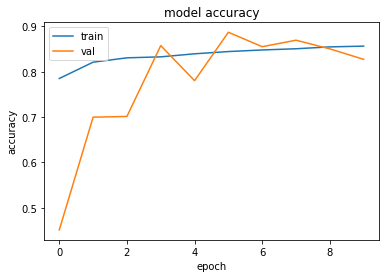

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Fine Tuning**

1. Batch Normalisation
2. Test DA1
3. Test DA2

## **Batch Normalisation**

In [46]:
headModel = model.output

headModel = BatchNormalization()(headModel)

headModel = Flatten()(headModel)

headModel = Dense(256, activation="relu")(headModel)

headModel = Dense(units=2, activation="softmax")(headModel)

finmodel = Model(inputs=model.input, outputs=headModel)


In [47]:
#freezing
for layer in model.layers:
	layer.trainable = False

In [48]:
finmodel.compile(optimizer=RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])
lr_red=ReduceLROnPlateau(patience=3,verbose=1,min_lr=0.0001)

H = finmodel.fit(X_train, Y_train, batch_size=128, epochs=10, callbacks=[lr_red], validation_data=(X_val, Y_val),)

Epoch 1/10
177/177 [==============================] - 3s 13ms/step - loss: 0.4846 - accuracy: 0.8005 - val_loss: 0.4229 - val_accuracy: 0.8662
Epoch 2/10
177/177 [==============================] - 2s 12ms/step - loss: 0.4171 - accuracy: 0.8397 - val_loss: 0.3827 - val_accuracy: 0.8591
Epoch 3/10
177/177 [==============================] - 2s 12ms/step - loss: 0.4214 - accuracy: 0.8390 - val_loss: 0.3730 - val_accuracy: 0.8599
Epoch 4/10
177/177 [==============================] - 2s 12ms/step - loss: 0.4190 - accuracy: 0.8386 - val_loss: 0.3693 - val_accuracy: 0.8639
Epoch 5/10
177/177 [==============================] - 2s 12ms/step - loss: 0.4236 - accuracy: 0.8348 - val_loss: 0.3715 - val_accuracy: 0.8607
Epoch 6/10
177/177 [==============================] - 2s 12ms/step - loss: 0.4251 - accuracy: 0.8362 - val_loss: 0.3759 - val_accuracy: 0.8599
Epoch 7/10
177/177 [==============================] - 2s 12ms/step - loss: 0.4172 - accuracy: 0.8399 - val_loss: 0.3693 - val_accuracy: 0.8615

In [49]:
def FinEval():

  print("Evaluate on test data")
  results = finmodel.evaluate(X_test, Y_test, batch_size=128)
  print("test loss, test acc:", results)

In [50]:
FinEval()

Evaluate on test data
10/10 [==============================] - 0s 11ms/step - loss: 0.4982 - accuracy: 0.7828
test loss, test acc: [0.49816522002220154, 0.7828162312507629]


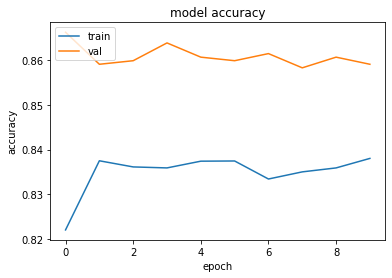

In [51]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Test DA1**

In [52]:
crop_test_64 = "/content/crop_testdata_64"
crop_test_80 = "/content/crop_testdata_80"
crop_test_88 = "/content/crop_testdata_88"
crop_test_100 = "/content/crop_testdata_100"

colt_path = "/content/colj_testdata"
flipt_path= "/content/flip_testdata"
augt_path = "/content/aug_testdata"

finres_test= "/content/finres_testdata"
res64_test = "/content/64res_testdata"
res80_test = "/content/80res_testdata"
res88_test = "/content/88res_testdata"
res100_test = "/content/100res_testdata"

In [53]:
#cropping test to 64,64
center_crop(test_path, crop_test_64, dim=(64,64))
#cropping test to 80,80
center_crop(test_path, crop_test_80, dim=(80,80))
#cropping test to 88,88
center_crop(test_path, crop_test_88, dim=(88,88)) #same as train
#cropping test to 100,100
center_crop(test_path, crop_test_100, dim=(100,100)) #same as val

Directory  /content/crop_testdata_64  Created 
Directory  /content/crop_testdata_80  Created 
Directory  /content/crop_testdata_88  Created 
Directory  /content/crop_testdata_100  Created 


**evaluate for 64x64**

In [54]:
preprocessing(crop_test_64, res64_test)
test_dataset,test_labels=vectorise(res64_test)

finx_test=test_dataset
finy_test=test_labels

finy_test_orig=finy_test.T

fin_X_test = finx_test/255. #normalising
fin_Y_test = convert_to_one_hot(finy_test_orig, 2).T #one hot encoding

print("Evaluate on 64x64 test data")
results = finmodel.evaluate(fin_X_test, fin_Y_test, batch_size=64)
print("test loss, test acc:", results)

Directory  /content/64res_testdata  Created 
Working with 1257 images
Files in path: 1257
All images to array!
Evaluate on 64x64 test data
20/20 [==============================] - 0s 10ms/step - loss: 0.3635 - accuracy: 0.8735
test loss, test acc: [0.36346378922462463, 0.8735083341598511]


**evaluate for 80x80**

In [55]:
preprocessing(crop_test_80, res80_test)

test_dataset,test_labels=vectorise(res80_test)

finx_test=test_dataset
finy_test=test_labels

finy_test_orig=finy_test.T

fin_X_test = finx_test/255. #normalising
fin_Y_test = convert_to_one_hot(finy_test_orig, 2).T #one hot encoding

print("Evaluate on 80x80 test data")
results = finmodel.evaluate(fin_X_test, fin_Y_test, batch_size=64)
print("test loss, test acc:", results)

Directory  /content/80res_testdata  Created 
Working with 1257 images
Files in path: 1257
All images to array!
Evaluate on 80x80 test data
20/20 [==============================] - 0s 7ms/step - loss: 0.3276 - accuracy: 0.8950
test loss, test acc: [0.32761672139167786, 0.8949880599975586]


**evaluate for 88x88**

In [56]:
preprocessing(crop_test_88, res88_test)

test_dataset,test_labels=vectorise(res88_test)

finx_test=test_dataset
finy_test=test_labels

finy_test_orig=finy_test.T

fin_X_test = finx_test/255. #normalising
fin_Y_test = convert_to_one_hot(finy_test_orig, 2).T #one hot encoding

print("Evaluate on 88x88 test data")
results = finmodel.evaluate(fin_X_test, fin_Y_test, batch_size=64)
print("test loss, test acc:", results)

Directory  /content/88res_testdata  Created 
Working with 1257 images
Files in path: 1257
All images to array!
Evaluate on 88x88 test data
20/20 [==============================] - 0s 7ms/step - loss: 0.3385 - accuracy: 0.8846
test loss, test acc: [0.3385099768638611, 0.8846459984779358]


**evaluate for 100x100**

In [57]:
preprocessing(crop_test_100, res100_test)

test_dataset,test_labels=vectorise(res100_test)

finx_test=test_dataset
finy_test=test_labels

finy_test_orig=finy_test.T

fin_X_test = finx_test/255. #normalising
fin_Y_test = convert_to_one_hot(finy_test_orig, 2).T #one hot encoding

print("Evaluate on 100x100 test data")
results = finmodel.evaluate(fin_X_test, fin_Y_test, batch_size=64)
print("test loss, test acc:", results)

Directory  /content/100res_testdata  Created 
Working with 1257 images
Files in path: 1257
All images to array!
Evaluate on 100x100 test data
20/20 [==============================] - 0s 7ms/step - loss: 0.3648 - accuracy: 0.8656
test loss, test acc: [0.36477991938591003, 0.8655529022216797]


## **test DA2**

In [58]:
#color jitter
colorJitter(5, test_path, colt_path)
#random horizontal flip
horizontalFlip(colt_path, flipt_path)
copy_data(colt_path, flipt_path)
augmentation(flipt_path,augt_path)

Directory  /content/colj_testdata  Created 
Directory  /content/flip_testdata  Created 
Directory  /content/aug_testdata  Created 


In [59]:
preprocessing(augt_path, finres_test)

test_dataset,test_labels=vectorise(finres_test)

finx_test=test_dataset
finy_test=test_labels

finy_test_orig=finy_test.T

fin_X_test = finx_test/255. #normalising
fin_Y_test = convert_to_one_hot(finy_test_orig, 2).T #one hot encoding

#evaluating for DA2
print("Evaluate on test data")
results = finmodel.evaluate(fin_X_test, fin_Y_test, batch_size=64)
print("test loss, test acc:", results)

Directory  /content/finres_testdata  Created 
Working with 1257 images
Files in path: 1257
All images to array!
Evaluate on test data
20/20 [==============================] - 0s 7ms/step - loss: 0.4996 - accuracy: 0.7852
test loss, test acc: [0.49961018562316895, 0.7852028608322144]


In [ ]:
finmodel.save("ft_model.h5")